In [9]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)


In [10]:
set.seed(50)
heart_data <- read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data", col_names = FALSE) |>
    #rename the columns
    rename("age"= X1, "sex" = X2, "chest_pain" = X3, "trestbps" = X4, "chol" = X5, "fasting_bs" = X6, "restecg" = X7, "max_heart_rate" = X8, "exang" = X9, "old_peak" = X10, "peak_slope" = X11, "ca" = X12, "thal" = X13, "predicted" = X14) |>
    #change the "sex" column observations from binary to "male" and "female"
    mutate(sex = recode(sex, "1" = "male", "0" = "female")) |>
    #change the "chest_pain" column from numeric to their given chest pain types.
    mutate(chest_pain = recode(chest_pain, "1" = "typical_angina", "2" = "atypical_angina", "3" = "non_anginal_pain", "4" = "asymptomatic")) |>
    #change restbps from dbl to in
    mutate(restbps = as.integer(trestbps)) |>
    #change cholesterol from dbl to int
    mutate(chol = as.integer(chol)) |>
    #change fasting blood sugar from binary to their given meanings
    mutate(fasting_bs = recode(fasting_bs, "1" = "over_120", "0" = "under_120")) |>
    #change the restecg from numeric to its given value meanings
    mutate(restecg = recode(restecg, "0" = "normal", "1" = "abnormal", "2" = "hypertrophy")) |>
    #change max_heart_rate from dbl to int
    mutate(max_heart_rate = as.integer(max_heart_rate)) |>
    #ensures is a dbl
    mutate(old_peak = as.numeric(old_peak)) |>
    #ensures the fluoroscopy data is an integer rather than a numeric value
    mutate(fluoro = as.integer(ca)) |>
    #changes values from binary to their given value meanings
    mutate(exang = recode(exang, "0" = "no", "1" = "yes")) |>
    #ensures the slope values are numeric
    mutate(peak_slope = as.integer(peak_slope)) |>
    #ensures the defect status has its given name rather than numbers associated with them
    mutate(thal = recode(thal, "3.0" = "normal", "6.0" = "fixed_defect", "7.0" = "reversable_defect")) |>
    #predicted is the HD diagnosis we wish to determine, therefore we turn it into a factor
    mutate(predicted = as.factor(predicted)) |>
    #Giving the numeric observations their given meanings.
    mutate(predicted = recode(predicted, "0" = "no_hd", "1" = "hd", "2" = "hd", "3" = "hd", "4" = "hd"))

#now that we have all of the data from the dataset labelled in a meaningful way, we select those relevant to our question.
heart_data_select <- heart_data |> select(age,restbps, chol, max_heart_rate, fluoro, predicted)
  
heart_data_select

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): X12, X13
dbl (12): X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”


age,restbps,chol,max_heart_rate,fluoro,predicted
<dbl>,<int>,<int>,<int>,<int>,<fct>
63,145,233,150,0,no_hd
67,160,286,108,3,hd
67,120,229,129,2,hd
⋮,⋮,⋮,⋮,⋮,⋮
57,130,131,115,1,hd
57,130,236,174,1,hd
38,138,175,173,NA,no_hd


In [11]:
heart_data_select <- heart_data_select |>
    na.omit()
heart_data_select

age,restbps,chol,max_heart_rate,fluoro,predicted
<dbl>,<int>,<int>,<int>,<int>,<fct>
63,145,233,150,0,no_hd
67,160,286,108,3,hd
67,120,229,129,2,hd
⋮,⋮,⋮,⋮,⋮,⋮
68,144,193,141,2,hd
57,130,131,115,1,hd
57,130,236,174,1,hd


In [13]:
#creating our training and testing data sets
set.seed(666) 
heart_split <- initial_split(heart_data_select, prop = 0.75, strata = predicted)
heart_train <- training(heart_split)
heart_test <- testing(heart_split)

heart_train

age,restbps,chol,max_heart_rate,fluoro,predicted
<dbl>,<int>,<int>,<int>,<int>,<fct>
67,160,286,108,3,hd
62,140,268,160,2,hd
53,140,203,155,0,hd
⋮,⋮,⋮,⋮,⋮,⋮
56,120,240,169,0,no_hd
55,132,342,166,0,no_hd
41,120,157,182,0,no_hd


In [46]:
#recipe + engine
set.seed(2023)
heart_recipe <- heart_train |>
    recipe(predicted ~ fluoro + max_heart_rate + chol + restbps + age) |>
     step_scale(all_predictors()) |>
        step_center(all_predictors())

heart_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
        set_engine("kknn") |>
        set_mode("classification")

#cross validation (10 folds)
folds <- heart_train |>
    vfold_cv(v = 10, strata = predicted) 

grid_vals <- tibble(neighbors = seq(from = 1, to = 100, by = 3))

heart_flow <- workflow() |>
    add_recipe(heart_recipe) |>
    add_model(heart_spec) |>
    tune_grid(resamples = folds, grid = grid_vals) |>
    collect_metrics() 



In [47]:
accuracy <- heart_flow |>
    filter(.metric == "accuracy") |>
    select(neighbors, mean) |>
    arrange(desc(mean))
accuracy

neighbors,mean
<dbl>,<dbl>
10,0.7940711
19,0.7851779
13,0.7808300
⋮,⋮
100,0.7177866
91,0.7175889
1,0.6681818


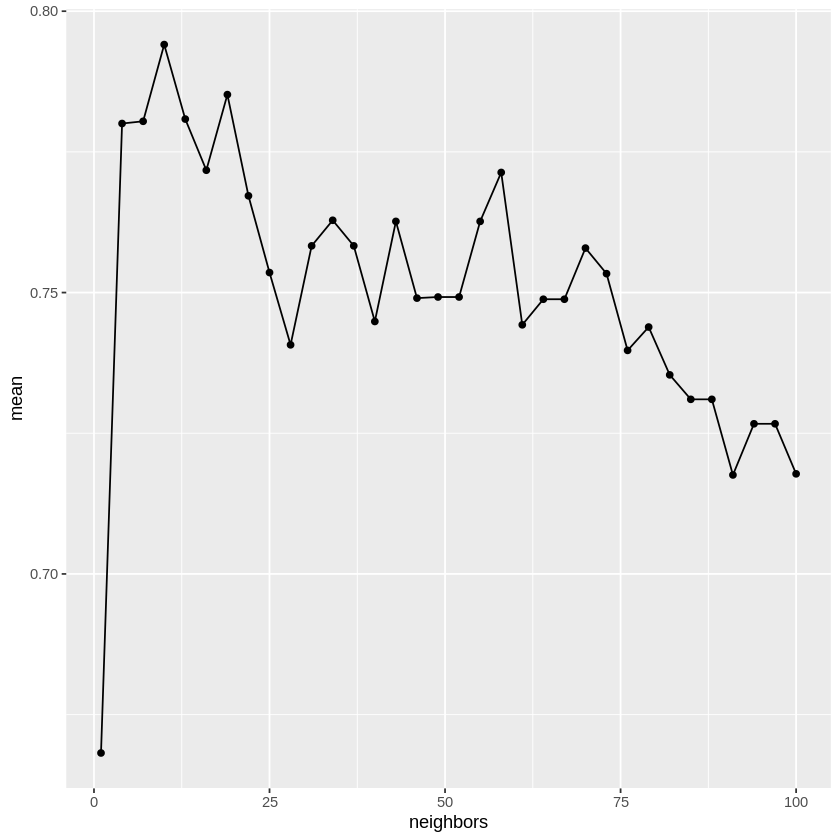

In [41]:
accuracy_plot <- accuracy |>
    ggplot(aes(x = neighbors, y = mean)) +
     geom_line() +
    geom_point()
accuracy_plot


In [21]:
#identical algorithim with a different seed
set.seed(666)
heart_split_666 <- initial_split(heart_data_select, prop = 0.75, strata = predicted)
heart_train_666 <- training(heart_split_666)
heart_test_666 <- testing(heart_split_666)

heart_train_666

age,restbps,chol,max_heart_rate,fluoro,predicted
<dbl>,<int>,<int>,<int>,<int>,<fct>
67,160,286,108,3,hd
62,140,268,160,2,hd
53,140,203,155,0,hd
⋮,⋮,⋮,⋮,⋮,⋮
56,120,240,169,0,no_hd
55,132,342,166,0,no_hd
41,120,157,182,0,no_hd


In [22]:
set.seed(666)
heart_recipe_666 <- heart_train_666 |>
    recipe(predicted ~ fluoro + max_heart_rate + chol + restbps + age) |>
     step_scale(all_predictors()) |>
        step_center(all_predictors())

heart_spec_666 <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
        set_engine("kknn") |>
        set_mode("classification")

#cross validation (10 folds)
folds <- heart_train_666 |>
    vfold_cv(v = 10, strata = predicted) 

grid_vals <- tibble(neighbors = seq(from = 1, to = 100, by = 3))

heart_flow_666 <- workflow() |>
    add_recipe(heart_recipe_666) |>
    add_model(heart_spec_666) |>
    tune_grid(resamples = folds, grid = grid_vals) |>
    collect_metrics() 

In [23]:
accuracy_666 <- heart_flow_666 |>
    filter(.metric == "accuracy") |>
    select(neighbors, mean) |>
    arrange(desc(mean))
accuracy_666

neighbors,mean
<dbl>,<dbl>
34,0.7300395
25,0.7213439
28,0.7209486
⋮,⋮
70,0.6851779
13,0.6760870
1,0.6541502


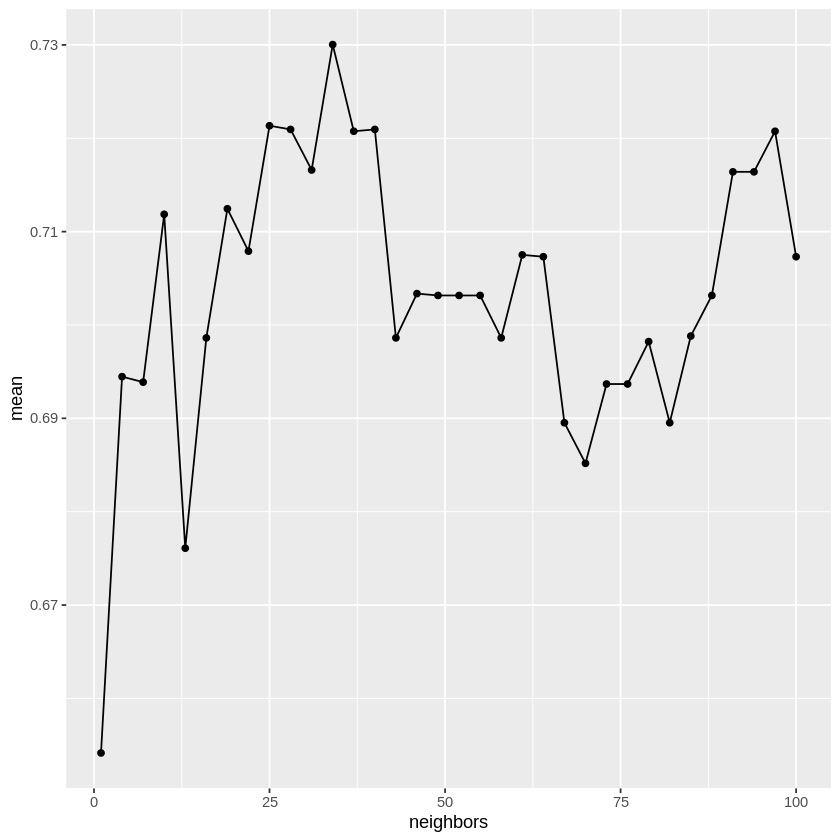

In [25]:
accuracy_plot_666 <- accuracy_666 |>
    ggplot(aes(x = neighbors, y = mean)) +
     geom_line() +
    geom_point()
accuracy_plot_666

In [26]:
#strong variance between seeds. I'll explain it in my part.